## EDA

In [1]:
"""
- Create discrete labels - DONE
- Preprocess images to grey-scale --> black-and-white
    - Pipeline 1st step: image type {1, 2, 3}
    - Transform accordingly to black-and-white image
    
- Data augmentation by gluing maps. This will allow the creation of more compact clusters (TODO)

STEPS:
0. Pre-process images to transform them to black-and-white
    0.1. Detect image type {0, 1, 2} - DONE
    0.2  Apply preprocessing for each image type - ...

1. Map image to cluster. CNN model.
    - for each cluster we store info like pixels /latitude, pixels / longitude.

2. Adjust image to find exact coordinates, plus/minus epsilon
    - template matching



-------------------------
TODOs:

# Check image type classification, this one does not work properly.
image_id = '4e4ae57cde'
-------------------------
"""

"\n- Create discrete labels - DONE\n- Preprocess images to grey-scale --> black-and-white\n    - Pipeline 1st step: image type {1, 2, 3}\n    - Transform accordingly to black-and-white image\n    \n- Data augmentation by gluing maps. This will allow the creation of more compact clusters (TODO)\n\nSTEPS:\n0. Pre-process images to transform them to black-and-white\n    0.1. Detect image type {0, 1, 2} - DONE\n    0.2  Apply preprocessing for each image type - ...\n\n1. Map image to cluster. CNN model.\n    - for each cluster we store info like pixels /latitude, pixels / longitude.\n\n2. Adjust image to find exact coordinates, plus/minus epsilon\n    - template matching\n\n\n\n-------------------------\nTODOs:\n\n# Check image type classification, this one does not work properly.\nimage_id = '4e4ae57cde'\n-------------------------\n"

In [19]:
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import random
import cv2
import glob
import pandas as pd

from sklearn.cluster import KMeans

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# own modules
from util import *
from data_generator import DataGenerator
from map_image import MapImage

import pdb

2.1.0


In [3]:
# IMAGE_WIDTH = 224
# IMAGE_HEIGHT = 224
# BATCH_SIZE = 8
IMAGES_DIR = 'data/train/'
# TEST_SPLIT = 0.50

### Load target coordindates from csv

In [6]:
train = pd.read_csv('data/train.csv', index_col=0)
trainNew = pd.read_csv('data/trainNew.csv', index_col=0)

target = pd.concat([train, trainNew], axis=0)

print(target.head(10))
print(len(target))

           id   llcrnrlon  llcrnrlat   urcrnrlon  urcrnrlat
0  aa5b6e01eb   52.635221  21.939847   60.276093  28.262239
1  e5a3b9d07d  123.974550  -6.746330  129.139013  -0.813028
2  3d7cedf92f  106.033993  10.328013  112.494841  18.005732
3  6f2fdf0368   54.051684  22.264178   59.123211  26.997385
4  5addc798b4  -40.403236  62.752617  -26.507330  70.153543
5  ddb27f85c0  -78.989740 -54.391308  -67.924797 -47.881368
6  d7e09a4a31  -52.643921  58.749963  -42.687544  62.697276
7  5bd2f2d225   77.343019   8.265528   82.347628  14.510404
8  89a14f09d8  -62.540592  44.760961  -55.601705  50.819461
9  980fc0a257  154.860601  67.369130  170.047838  71.235238
40000


In [7]:
print('max llcrnrlon: ', target['llcrnrlon'].max())
print('min llcrnrlon: ', target['llcrnrlon'].min())
print('max llcrnrlat: ', target['llcrnrlat'].max())
print('min llcrnrlat: ', target['llcrnrlat'].min())

max llcrnrlon:  179.97568800242013
min llcrnrlon:  -179.98753118110784
max llcrnrlat:  68.95519059854956
min llcrnrlat:  -60.21649864109493


In [20]:
# map_id_to_coordinates = dict()
# for i, row in target.iterrows():
#     image_id = row['id']
#     ll_lon = row['llcrnrlon']
#     ll_lat = row['llcrnrlat']
#     ur_lon = row['urcrnrlon']
#     ur_lat = row['urcrnrlat']
#     map_id_to_coordinates[image_id] = {
#         'll_lon': ll_lon,
#         'll_lat': ll_lat,
#         'ur_lon': ur_lon,
#         'ur_lat': ur_lat
#     }
map_id_to_actual_coordinates = dict()
for _, row in target.iterrows(): 
    map_id_to_actual_coordinates[row['id']] = [row['llcrnrlon'],
                                               row['llcrnrlat'],
                                               row['urcrnrlon'],
                                               row['urcrnrlat']]

map_id_to_path = dict()
for id_ in target['id']:
    map_id_to_path[id_] = id2path(IMAGES_DIR, id_)

### Visualization to Tableau

In [31]:
# grid = list()
# for lon in range(-180, 180, 1):
#     for lat in range(-70, 70, 1):
#         grid.append({'lon': lon, 'lat': lat})

# grid = pd.DataFrame(grid)
# grid['num_images'] = 0
# # print(grid)

# for _, row in tqdm(target.iterrows()):
#     ll_lon = row['llcrnrlon']
#     ll_lat = row['llcrnrlat']
#     ur_lon = row['urcrnrlon']
#     ur_lat = row['urcrnrlat']
    
#     condition_lat = (grid['lat'] > ll_lat) & (grid['lat'] < ur_lat)
#     condition_lon = (grid['lon'] > ll_lon) & (grid['lon'] < ur_lon)

#     grid.loc[condition_lat & condition_lon, 'num_images'] += 1

# grid.to_csv('eda/grid.csv', index=False)
# grid.sort_values(by=['num_images'], inplace=True, ascending=False)

# grid.head()

### Find optimal number of clusters

In [9]:
data = target[['llcrnrlon', 'llcrnrlat', 'urcrnrlon', 'urcrnrlat']].to_numpy()

In [10]:
# Create clusters of images, based on their distance
avg_distances = list()

for c in range(50, 200, 50):
    
    # fit clusters
    kmeans = KMeans(n_clusters=c, random_state=12345)
    kmeans = kmeans.fit(data)
    
    # compute average distance from each image to its cluster center
    # we want this number small enough, for this 
    # discretization to make sense 
    
    # construct dataframe with cluster center for each image
    centers = np.empty((len(data), 4))
    for i, label in enumerate(kmeans.labels_):
        center = kmeans.cluster_centers_[label]
        centers[i, :] = center

    distances = np.sqrt(np.sum(np.square(data - centers), axis=1))
    avg_distance = round(np.mean(distances), 1)
    avg_distances.append(avg_distance)
#     pdb.set_trace()
    
    print(f'{c} clusters, {avg_distance} avg distance, {kmeans.n_iter_} iterations')

50 clusters, 9.0 avg distance, 17 iterations
100 clusters, 5.6 avg distance, 14 iterations
150 clusters, 4.3 avg distance, 17 iterations


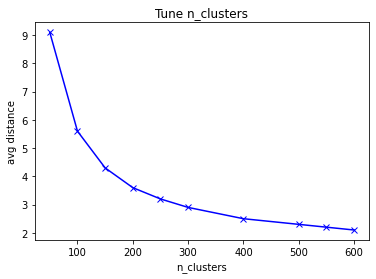

In [116]:
plt.plot(n_clusters, avg_distances, 'bx-')
plt.xlabel('n_clusters')
plt.ylabel('avg distance')
plt.title('Tune n_clusters')
plt.show()

In [11]:
n_optimal_clusters = 150

kmeans = KMeans(n_clusters=n_optimal_clusters, random_state=12345)
kmeans = kmeans.fit(data)
labels = kmeans.predict(data)

target['class'] = labels

In [37]:
map_id_to_actual_class = dict()
for _, row in target.iterrows():
    map_id_to_actual_class[row['id']] = row['class']

In [74]:
# construct dataframe with cluster center for each image
centers = np.empty((len(target), 4))
for i, label in enumerate(kmeans.labels_):
    center = kmeans.cluster_centers_[label]
    centers[i, :] = center

distances = np.sqrt(np.sum(np.square(data - centers), axis=1))
target['distance'] = distances
target

id   llcrnrlon  llcrnrlat   urcrnrlon  urcrnrlat  class  \
0      aa5b6e01eb   52.635221  21.939847   60.276093  28.262239    142   
1      e5a3b9d07d  123.974550  -6.746330  129.139013  -0.813028     26   
2      3d7cedf92f  106.033993  10.328013  112.494841  18.005732     13   
3      6f2fdf0368   54.051684  22.264178   59.123211  26.997385    142   
4      5addc798b4  -40.403236  62.752617  -26.507330  70.153543     90   
...           ...         ...        ...         ...        ...    ...   
39995  1b46b2f659    7.445420  53.306584   15.020541  57.926219    105   
39996  d99c3e8365    8.271182  53.009906   15.479329  56.659583    105   
39997  7a06a12b53  122.410910   9.150275  128.581979  15.042010     53   
39998  6afb27f9c5  118.375456 -12.817320  125.647640  -4.235364     76   
39999  3f2429ea5f   11.217569  36.515087   19.175652  44.126165     67   

       distance  
0      2.389506  
1      4.784869  
2      7.727720  
3      1.837597  
4      1.396137  
...         ...  
39995  1.542073  
39996  2.197831  
39997  4.857523  
39998  2.878093  
39999  2.719133  

[40000 rows x 7 columns]

## Visualize distribution of image resolutions

In [75]:
map_id_to_distance_center = dict()
for _, row in target.iterrows():
    map_id_to_distance_center[row['id']] = row['distance']

In [84]:
output = list()

for _, row in tqdm(target[:10].iterrows()):
    image_id = row['id']
    cluster = row['class']
    
    map_image = MapImage(image_id=image_id,
                         image_path=map_id_to_path[image_id],
                         coordinates=map_id_to_actual_coordinates[image_id])
    
    # polar coordinates
    angle_with_center = map_image.
    distance_to_center = map_id_to_distance_center[image_id]
    
    output.append({
        'image_id': image_id,
        'cluster': cluster,
        'px_per_lon_ratio': int(map_image.px_per_lon_ratio),
        'px_per_lat_ratio': int(map_image.px_per_lat_ratio),
        'll_lon': round(map_image.ll_lon, 3),
        'll_lat': round(map_image.ll_lat, 3),
        'ur_lon': round(map_image.ur_lon, 3),
        'ur_lat': round(map_image.ur_lat, 3),
        'distance_to_center': round(map_id_to_distance_center[image_id], 2)
    })
    
    del map_image

output = pd.DataFrame(output)
output.to_csv('eda/metadata.csv', index=False)

10000it [04:44, 35.14it/s]


In [81]:
map_id_to_metadata = dict()
for _, row in output.iterrows():
    map_id_to_metadata[row['image_id']] = {
        'px_per_lon_ratio': row['px_per_lon_ratio'],
        'px_per_lat_ratio': row['px_per_lat_ratio'],
        'distance_to_center': row['distance_to_center']
    }

In [85]:
map_id_to_metadata

{'aa5b6e01eb': {'px_per_lon_ratio': 196,
  'px_per_lat_ratio': 216,
  'distance_to_center': 2.39},
 'e5a3b9d07d': {'px_per_lon_ratio': 252,
  'px_per_lat_ratio': 252,
  'distance_to_center': 4.78},
 '3d7cedf92f': {'px_per_lon_ratio': 189,
  'px_per_lat_ratio': 195,
  'distance_to_center': 7.73},
 '6f2fdf0368': {'px_per_lon_ratio': 287,
  'px_per_lat_ratio': 316,
  'distance_to_center': 1.84},
 '5addc798b4': {'px_per_lon_ratio': 78,
  'px_per_lat_ratio': 202,
  'distance_to_center': 1.4},
 'ddb27f85c0': {'px_per_lon_ratio': 135,
  'px_per_lat_ratio': 217,
  'distance_to_center': 3.28},
 'd7e09a4a31': {'px_per_lon_ratio': 150,
  'px_per_lat_ratio': 310,
  'distance_to_center': 6.34},
 '5bd2f2d225': {'px_per_lon_ratio': 235,
  'px_per_lat_ratio': 240,
  'distance_to_center': 1.4},
 '89a14f09d8': {'px_per_lon_ratio': 165,
  'px_per_lat_ratio': 247,
  'distance_to_center': 5.22},
 '980fc0a257': {'px_per_lon_ratio': 98,
  'px_per_lat_ratio': 284,
  'distance_to_center': 5.49},
 '25cc8cb23c':

In [40]:
map_class_to_image_ids = dict()
for image_id in target['id']:
    c = map_id_to_actual_class[image_id]
    if c in map_class_to_image_ids:
        map_class_to_image_ids[c].append(image_id)
    else:
        map_class_to_image_ids[c] = [image_id]

In [67]:
cluster = 47
image_ids = map_class_to_image_ids[cluster]
ids_with_metadata = [i for i in map_id_to_metadata.keys()]

print(len(image_ids))
image_ids = list(set(image_ids) & set(ids_with_metadata))  
print(len(image_ids))

# enough to work with horizontal resolution (h and v are highly correlated)
h_res = [map_id_to_metadata[i]['px_per_lon_ratio'] for i in image_ids]
print(min(h_res), max(h_res))

n_maps_to_extract = 10
max_maps_per_bucket = 1

h_res_min = min(h_res)
h_res_max = max(h_res)
step = (h_res_max - h_res_min)/n_maps_to_extract

def get_maps_with_diverse_resolution():
    
    selected_image_ids = list()
    n_maps_per_bucket = dict()
    
    for image_id in image_ids:
        # resolution
        h_res = map_id_to_metadata[image_id]['px_per_lon_ratio']
        
        bucket = int((h_res - h_res_min)/step)
        n_maps_in_this_bucket = n_maps_per_bucket.get(bucket, 0)
        
        if n_maps_in_this_bucket < max_maps_per_bucket:
            # pick this map
            selected_image_ids.append(image_id)
            
            # update counter
            n_maps_per_bucket[bucket] = n_maps_in_this_bucket + 1
    
    return selected_image_ids

selected_image_ids = get_maps_with_diverse_resolution()

output = [map_id_to_metadata[i] for i in selected_image_ids]
output.sort(key=lambda x: x['px_per_lon_ratio'], reverse=False)
output

237
62
144 317


[{'px_per_lon_ratio': 144, 'px_per_lat_ratio': 165},
 {'px_per_lon_ratio': 175, 'px_per_lat_ratio': 194},
 {'px_per_lon_ratio': 192, 'px_per_lat_ratio': 216},
 {'px_per_lon_ratio': 206, 'px_per_lat_ratio': 239},
 {'px_per_lon_ratio': 215, 'px_per_lat_ratio': 244},
 {'px_per_lon_ratio': 240, 'px_per_lat_ratio': 272},
 {'px_per_lon_ratio': 260, 'px_per_lat_ratio': 295},
 {'px_per_lon_ratio': 282, 'px_per_lat_ratio': 311},
 {'px_per_lon_ratio': 299, 'px_per_lat_ratio': 340},
 {'px_per_lon_ratio': 314, 'px_per_lat_ratio': 352},
 {'px_per_lon_ratio': 317, 'px_per_lat_ratio': 347}]

In [63]:
selected_image_ids

['91babbe3f8',
 '63c878514e',
 '02976ac33e',
 'a334d5ded4',
 'dc02e0dc48',
 'a8fe75583a',
 'd549d56b0d',
 '4ef65e5408',
 '316e3376e4',
 'e6db47f4e5']

## Use color distributions to filter out artificial straight lines from maps

-------------
4b735849ae


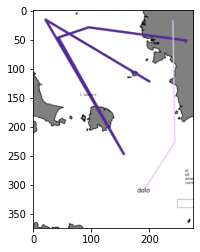

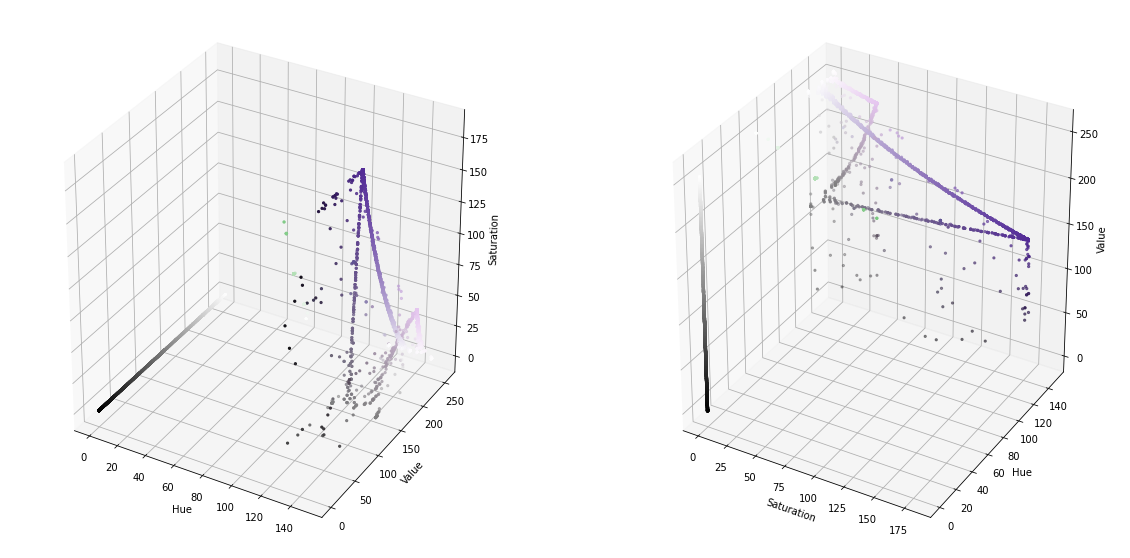

-------------


In [24]:
N_EXAMPLES_TO_PLOT = 10
n_examples_plotted = 0

for image_id in target['id']:

    map_image = MapImage(image_id=image_id, image_path=map_id_to_path[image_id])
    if map_image.image_type != 'blue-green':
        continue

    print('-------------')
    print(map_image.image_id)
    
    map_image.resize_by_scaling_factor(0.25)
    map_image.plot()

    map_image.plot_hsv_3d_scatterplot()   
    
    print('-------------')
    
    n_examples_plotted += 1
    if n_examples_plotted >= N_EXAMPLES_TO_PLOT:
        break

In [148]:
# Check image type classification, this one does not work properly.
image_id = '4e4ae57cde'

694967dc9a


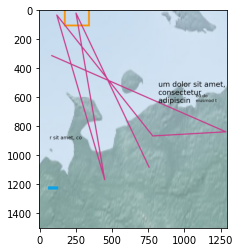

Pre-processing new method:


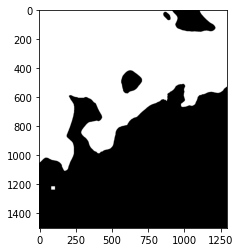

-------------
13e689e0ec


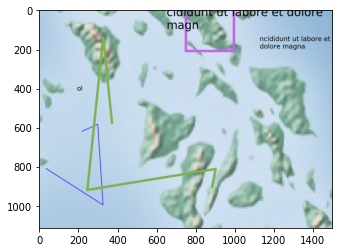

Pre-processing new method:


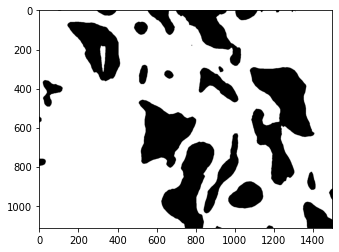

-------------
35abd7eeec


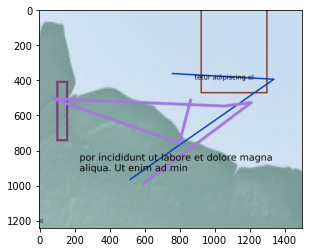

Pre-processing new method:


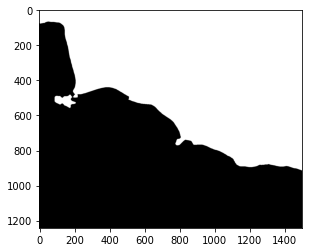

-------------
8f67b5d9b9


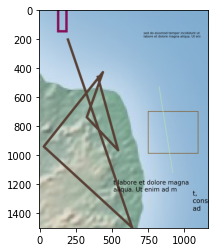

Pre-processing new method:


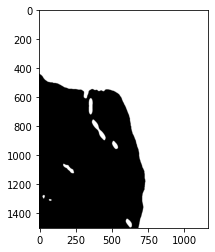

-------------
a96c660f2b


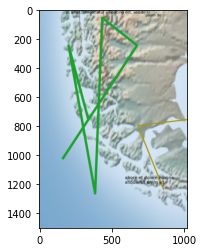

Pre-processing new method:


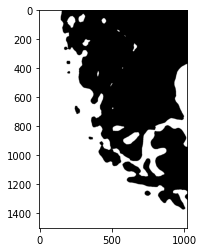

-------------
93990d2e9c


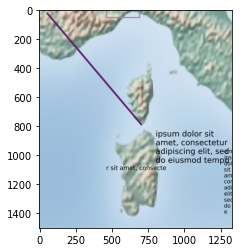

Pre-processing new method:


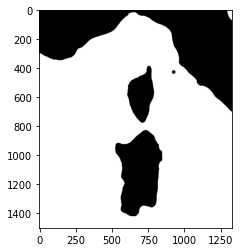

-------------
11abfe538e


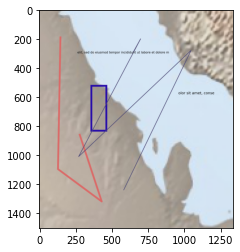

Pre-processing new method:


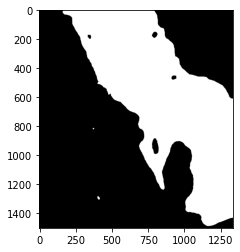

-------------
6f2fdf0368


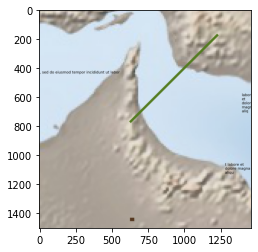

Pre-processing new method:


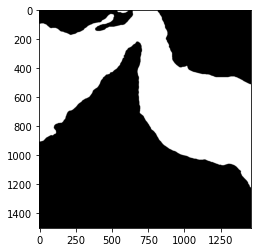

-------------
02e88f7ca4


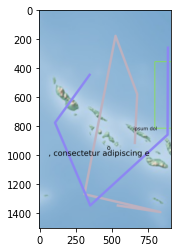

Pre-processing new method:


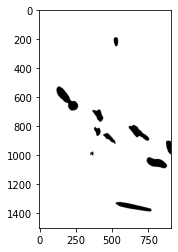

-------------
afd429d01b


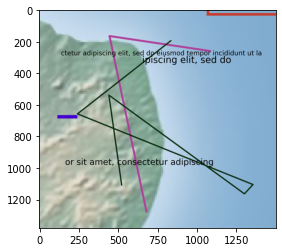

Pre-processing new method:


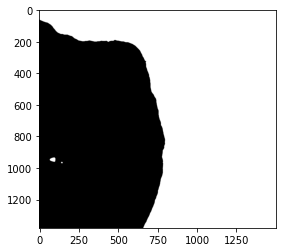

-------------
89a14f09d8


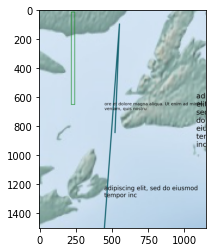

Pre-processing new method:


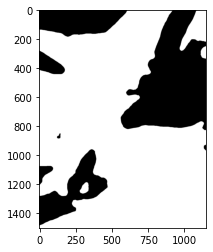

-------------
e630f81f0d


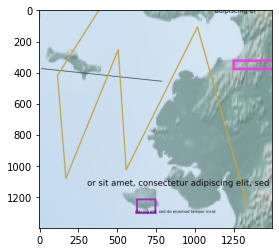

Pre-processing new method:


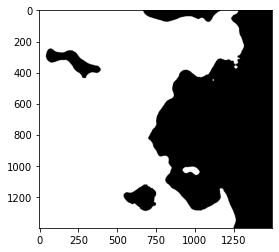

-------------
69311a370c


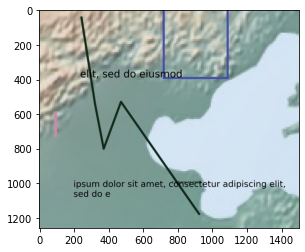

Pre-processing new method:


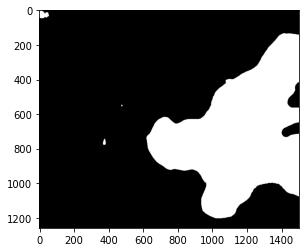

-------------
a9f30be6d4


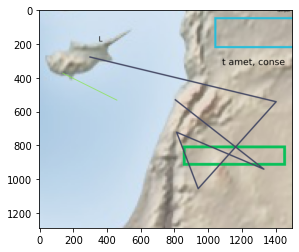

Pre-processing new method:


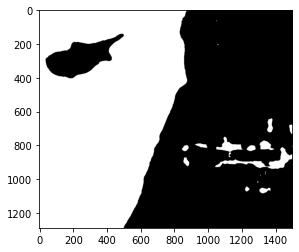

-------------
a91c9e99fd


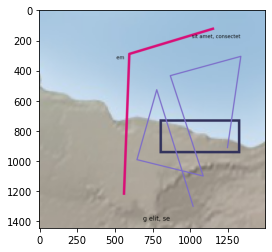

Pre-processing new method:


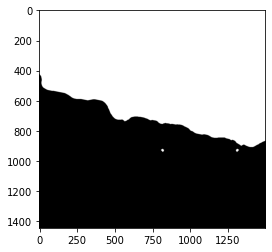

-------------
1a4f71e9da


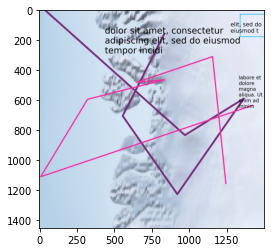

Pre-processing new method:


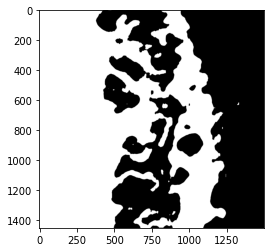

-------------
91870ddb76


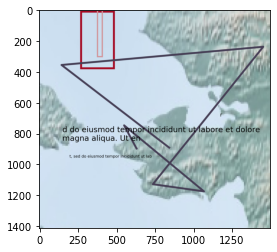

Pre-processing new method:


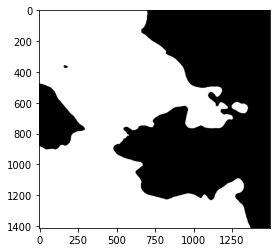

-------------
ef1eaac088


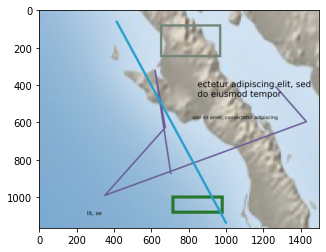

Pre-processing new method:


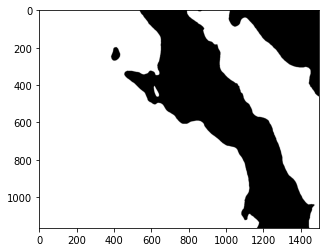

-------------
25cc8cb23c


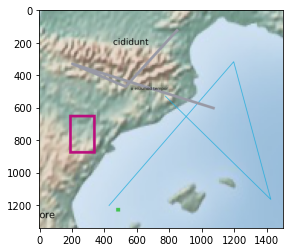

Pre-processing new method:


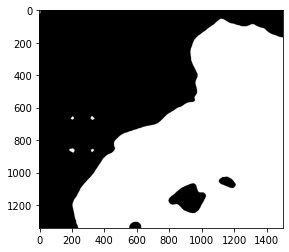

-------------
c5eedff4ee


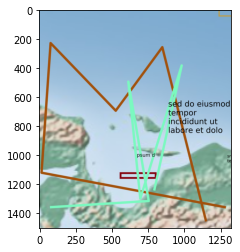

Pre-processing new method:


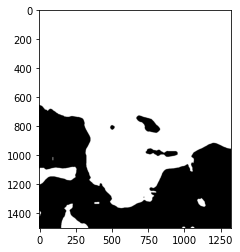

-------------
b5e132fc97


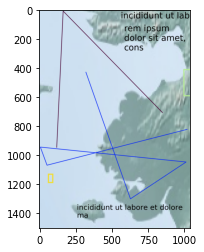

Pre-processing new method:


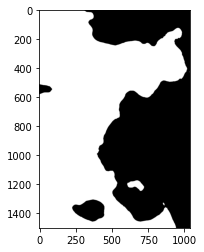

-------------
ecee53d5bc


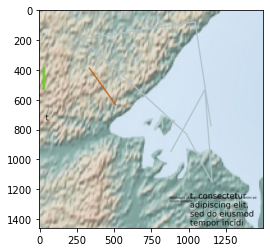

Pre-processing new method:


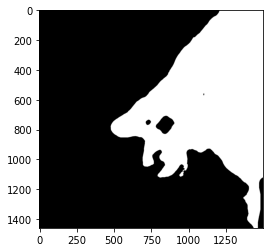

-------------
113fe3e222


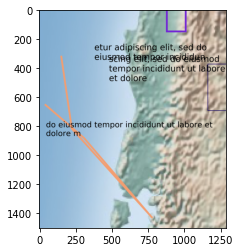

Pre-processing new method:


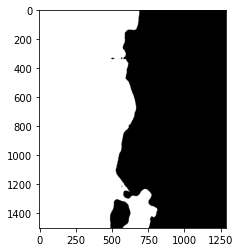

-------------
dda2e01267


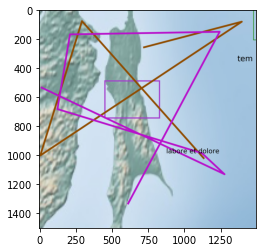

Pre-processing new method:


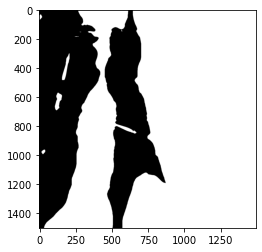

-------------
cb84f7804e


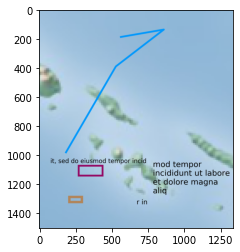

Pre-processing new method:


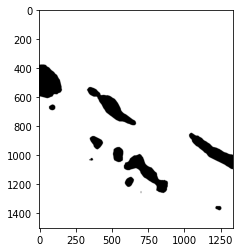

-------------
4ece84d372


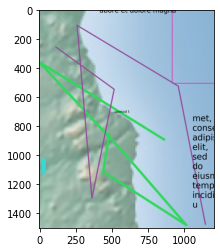

Pre-processing new method:


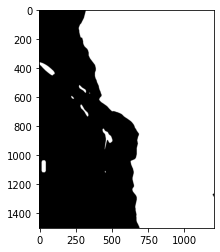

-------------
34d040bc0c


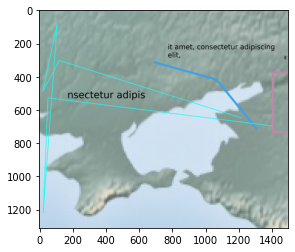

Pre-processing new method:


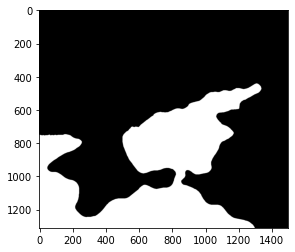

-------------
adfc5b3e00


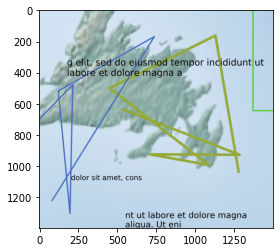

Pre-processing new method:


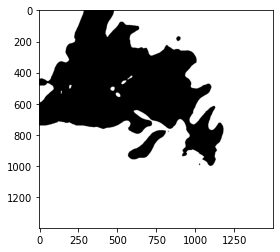

-------------
8409758825


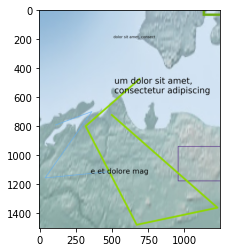

Pre-processing new method:


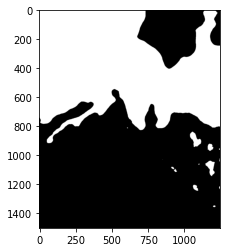

-------------
f7821b979b


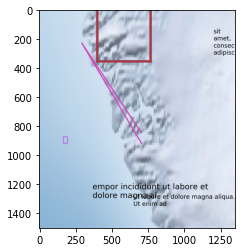

Pre-processing new method:


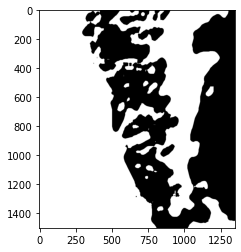

-------------
58dd56040d


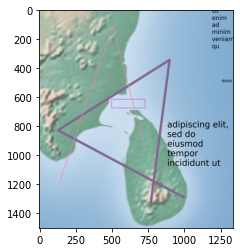

Pre-processing new method:


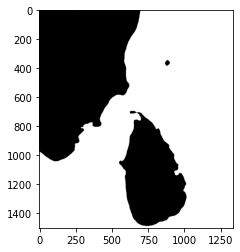

-------------
980fc0a257


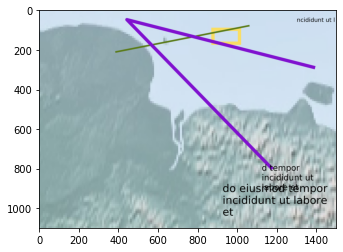

Pre-processing new method:


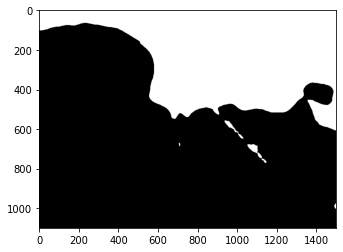

-------------
6efc78f9b6


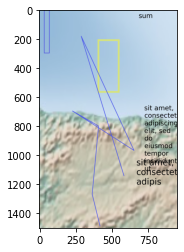

Pre-processing new method:


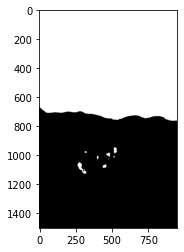

-------------
7c174283d7


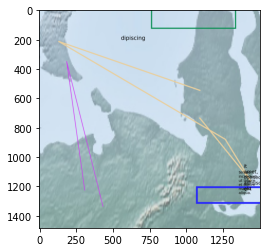

Pre-processing new method:


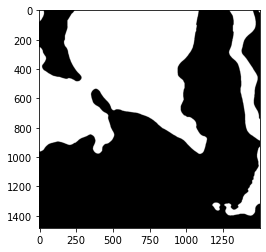

-------------


In [106]:
N_EXAMPLES_TO_PLOT = 100
n_examples_plotted = 0

image_ids = target['id'][:100].tolist()
random.shuffle(image_ids)

# for image_id in target['id'][:100]:
# for image_id in ['1a4f71e9da']:
for image_id in image_ids:  
    map_image = MapImage(image_id=image_id, image_path=map_id_to_path[image_id])
    
    if map_image.image_type != 'blue-green':
        continue

    print(image_id)
    map_image.plot()
    
    # PROVISIONAL
#     print('Pre-processing old method:')
#     map_image_2 = MapImage(image_id=image_id, image_path=map_id_to_path[image_id])
#     map_image_2.preprocess_image_old()
#     map_image_2.plot()

    print('Pre-processing new method:')
    map_image.preprocess_image_new()
    map_image.plot()     
    
    print('-------------')
    
    n_examples_plotted += 1
    if n_examples_plotted >= N_EXAMPLES_TO_PLOT:
        break
        

### Check image_type is correctly computed

Ratio white pixels:  0.3224196450279601
Ratio gray pixels:  0.6209404327741308
Ratio orange pixels:  0.0
aa5b6e01eb
white-gray


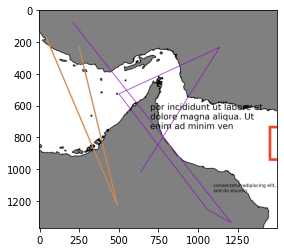

Ratio white pixels:  0.9176694806855974
Ratio gray pixels:  0.0553804041954464
Ratio orange pixels:  0.0
e5a3b9d07d
white-gray


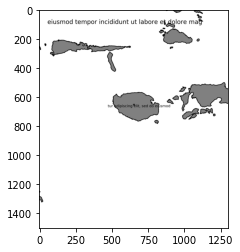

Ratio white pixels:  0.5906546840958605
Ratio gray pixels:  0.36537745098039215
Ratio orange pixels:  0.0
3d7cedf92f
white-gray


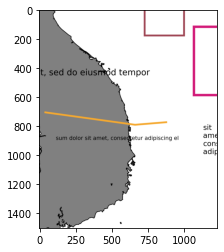

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5068901098901099
Ratio gray pixels:  0.3989145299145299
Ratio orange pixels:  0.0
5addc798b4
white-gray


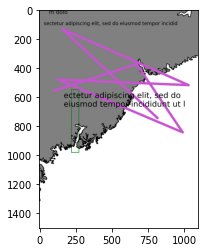

Ratio white pixels:  0.43565303244005643
Ratio gray pixels:  4.372355430183357e-05
Ratio orange pixels:  0.4258354489891866
Ratio white pixels:  0.5968
Ratio gray pixels:  0.2907891156462585
Ratio orange pixels:  0.0
d7e09a4a31
white-gray


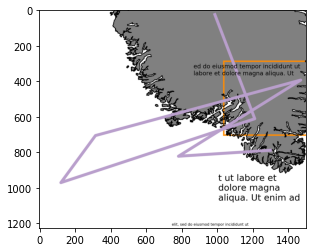

Ratio white pixels:  0.4790871533672892
Ratio gray pixels:  0.4882161856253537
Ratio orange pixels:  0.0
5bd2f2d225
white-gray


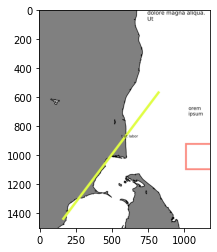

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.365717082721488
Ratio gray pixels:  0.5239618208516887
Ratio orange pixels:  0.0
8f8fccd389
white-gray


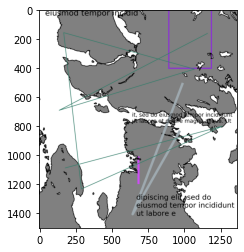

Ratio white pixels:  0.4520931899641577
Ratio gray pixels:  5.632360471070149e-06
Ratio orange pixels:  0.5090030721966206
Ratio white pixels:  0.619071297989031
Ratio gray pixels:  1.6453382084095066e-05
Ratio orange pixels:  0.33786532602071906
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6780762928827445
Ratio gray pixels:  1.9969278033794163e-05
Ratio orange pixels:  0.20716026625704045
Ratio white pixels:  0.48449893390191895
Ratio gray pixels:  0.44157829898128403
Ratio orange pixels:  0.0
cbf2163a8f
white-gray


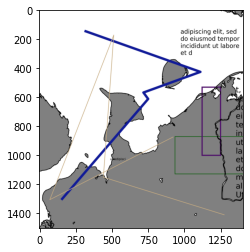

Ratio white pixels:  0.49682799748901446
Ratio gray pixels:  2.071563088512241e-05
Ratio orange pixels:  0.43410043942247334
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.42742249551626954
Ratio gray pixels:  0.5090904432487829
Ratio orange pixels:  0.0
e99081ebc2
white-gray


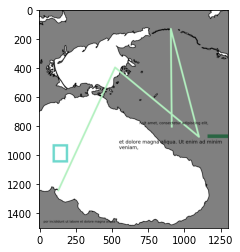

Ratio white pixels:  0.6773711897738447
Ratio gray pixels:  0.2464464110127827
Ratio orange pixels:  0.0
8b0c9f4637
white-gray


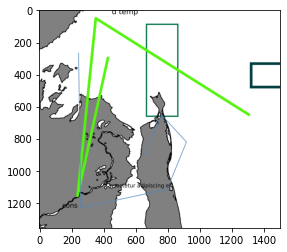

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.23179415204678364
Ratio gray pixels:  1.0760233918128655e-05
Ratio orange pixels:  0.7239485380116959
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7189141653501843
Ratio gray pixels:  2.6856240126382308e-05
Ratio orange pixels:  0.1965676671932596
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7445456989247312
Ratio gray pixels:  2.6881720430107527e-05
Ratio orange pixels:  0.15534408602150537
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5827893601725378
Ratio gray pixels:  2.923556194584232e-05
Ratio orange pixels:  0.36308698777857656
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3532967450700879
Ratio gray pixels:  2.0907578997386553e-05
Ratio orange pixels:  0.5631142789261108
Rat

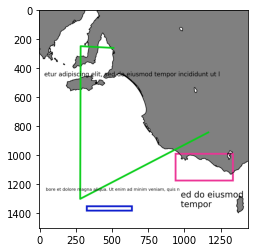

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3674503570605851
Ratio gray pixels:  2.02718267680258e-05
Ratio orange pixels:  0.4997521308454273
Ratio white pixels:  0.5303026744944553
Ratio gray pixels:  0.39523287671232876
Ratio orange pixels:  0.0
b982c5ca4c
white-gray


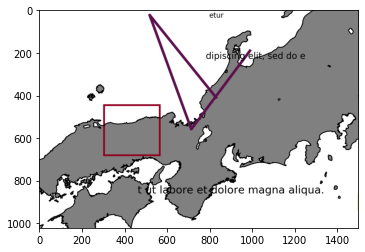

Ratio white pixels:  0.830450271674935
Ratio gray pixels:  1.5591778880226788e-05
Ratio orange pixels:  0.08580817387195842
Ratio white pixels:  0.6225604719764012
Ratio gray pixels:  2.6057030481809244e-05
Ratio orange pixels:  0.27310226155358897
Ratio white pixels:  0.4121444805194805
Ratio gray pixels:  0.5062310606060606
Ratio orange pixels:  0.0
226e49103d
white-gray


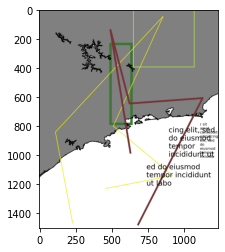

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.22919410569105692
Ratio gray pixels:  0.7254192073170732
Ratio orange pixels:  0.0
16cb7305d0
white-gray


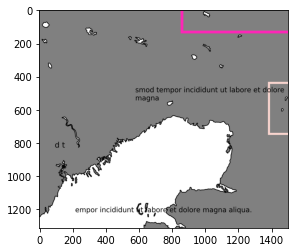

Ratio white pixels:  0.39797449104733873
Ratio gray pixels:  0.5132675987245524
Ratio orange pixels:  0.0
e7c1791e61
white-gray


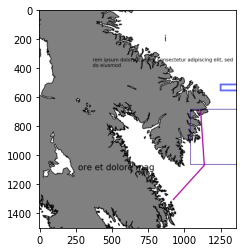

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4876503560762692
Ratio gray pixels:  0.43729887433953596
Ratio orange pixels:  0.0
851b87b61d
white-gray


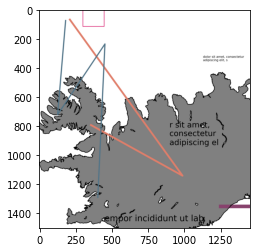

Ratio white pixels:  0.3502021570102834
Ratio gray pixels:  1.7557060446450967e-05
Ratio orange pixels:  0.5248908954100827
Ratio white pixels:  0.6966217167614406
Ratio gray pixels:  2.057947468183049e-05
Ratio orange pixels:  0.2278998104522069
Ratio white pixels:  0.4311196515500897
Ratio gray pixels:  5.636689725851909e-06
Ratio orange pixels:  0.5081983089930823
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.16938492328218813
Ratio gray pixels:  0.739521458750278
Ratio orange pixels:  0.0
8775e35831
white-gray


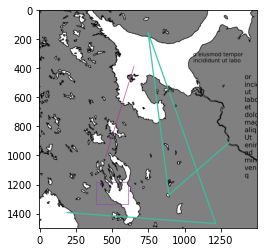

Ratio white pixels:  0.4901980749746707
Ratio gray pixels:  2.735562310030395e-05
Ratio orange pixels:  0.3972107396149949
Ratio white pixels:  0.23276848249027238
Ratio gray pixels:  2.0752269779507135e-05
Ratio orange pixels:  0.6299688715953308
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.8912206143691292
Ratio white pixels:  0.49516129032258066
Ratio gray pixels:  9.55794504181601e-06
Ratio orange pixels:  0.4674661887694146
Ratio white pixels:  0.6923962390866353
Ratio gray pixels:  0.25339959704499665
Ratio orange pixels:  0.0
086b95b7e3
white-gray


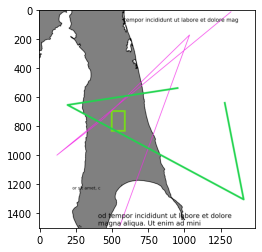

Ratio white pixels:  0.7223277467411545
Ratio gray pixels:  0.2059669459962756
Ratio orange pixels:  0.0
97ad8fed95
white-gray


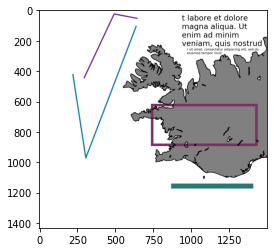

Ratio white pixels:  0.41642956521739133
Ratio gray pixels:  1.2753623188405797e-05
Ratio orange pixels:  0.49968927536231883
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7359466446644665
Ratio gray pixels:  0.12141089108910891
Ratio orange pixels:  0.0
411a38871b
white-gray


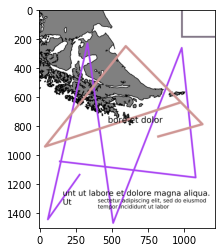

Ratio white pixels:  0.5966215538847118
Ratio gray pixels:  7.240323029796714e-06
Ratio orange pixels:  0.32141966026176555
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4809459264599856
Ratio gray pixels:  0.46593366979091566
Ratio orange pixels:  0.0
7b1f6ff8dd
white-gray


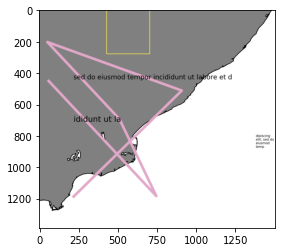

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.27475805999439307
Ratio gray pixels:  4.0370058873002523e-05
Ratio orange pixels:  0.6083212783851977
Ratio white pixels:  0.8009477447744775
Ratio gray pixels:  1.4851485148514851e-05
Ratio orange pixels:  0.1404928492849285
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.49877805907172995
Ratio gray pixels:  2.8129395218002813e-06
Ratio orange pixels:  0.43703347398030945
Ratio white pixels:  0.4315737122557726
Ratio gray pixels:  0.5279100059206631
Ratio orange pixels:  0.0
2ae6179578
white-gray


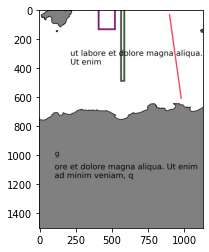

Ratio white pixels:  0.5196485714285715
Ratio gray pixels:  1.0952380952380953e-05
Ratio orange pixels:  0.44911047619047617
Ratio white pixels:  0.7392822299651568
Ratio gray pixels:  0.22038373983739837
Ratio orange pixels:  0.0
5c6dfc9d23
white-gray


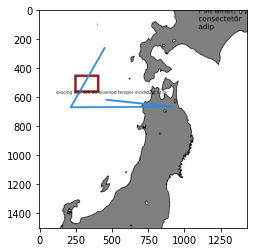

Ratio white pixels:  0.7129430411094602
Ratio gray pixels:  3.665180782565627e-05
Ratio orange pixels:  0.1889732540861813
Ratio white pixels:  0.5469945872801083
Ratio gray pixels:  1.2178619756427604e-05
Ratio orange pixels:  0.419829950383401
Ratio white pixels:  0.41
Ratio gray pixels:  6.2801932367149755e-06
Ratio orange pixels:  0.5096811594202899
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7256794785345021
Ratio gray pixels:  2.4724657226343e-05
Ratio orange pixels:  0.20818745785569792
Ratio white pixels:  0.5345764362220058
Ratio gray pixels:  0.3852593313859137
Ratio orange pixels:  0.0
02afd5ca38
white-gray


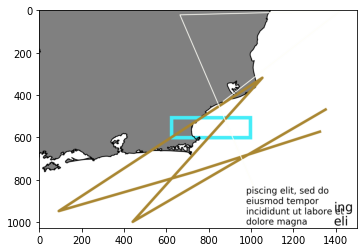

Ratio white pixels:  0.4160660276890309
Ratio gray pixels:  0.4536606318778843
Ratio orange pixels:  0.0
314d283017
white-gray


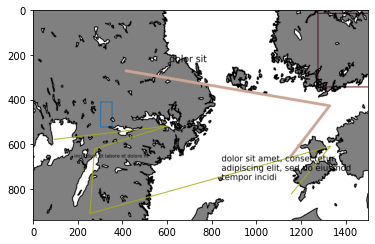

Ratio white pixels:  0.5021791812865497
Ratio gray pixels:  1.2163742690058479e-05
Ratio orange pixels:  0.4601787134502924
Ratio white pixels:  0.4537592458303118
Ratio gray pixels:  1.5953589557650472e-05
Ratio orange pixels:  0.4925931834662799
Ratio white pixels:  0.4707497194163861
Ratio gray pixels:  7.856341189674523e-06
Ratio orange pixels:  0.45551907968574634
Ratio white pixels:  0.6966737891737892
Ratio gray pixels:  0.2537597340930674
Ratio orange pixels:  0.0
14c75cb024
white-gray


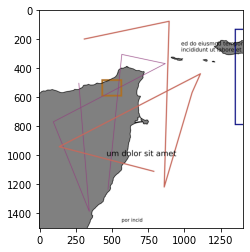

Ratio white pixels:  0.7056837606837607
Ratio gray pixels:  3.258547008547008e-05
Ratio orange pixels:  0.20981944444444445
Ratio white pixels:  0.22503367003367003
Ratio gray pixels:  2.7417027417027418e-05
Ratio orange pixels:  0.6611746031746032
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.28896414950419524
Ratio gray pixels:  1.906941266209001e-05
Ratio orange pixels:  0.5527017543859649
Ratio white pixels:  0.7889771505376344
Ratio gray pixels:  0.17007078853046595
Ratio orange pixels:  0.0
299796336a
white-gray


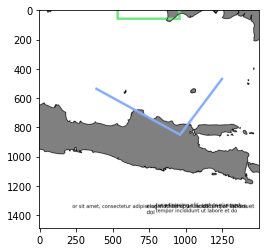

Ratio white pixels:  0.5208008270158512
Ratio gray pixels:  0.44681415116011947
Ratio orange pixels:  0.0
2cd03bb0d6
white-gray


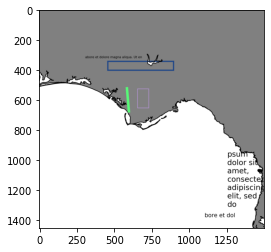

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.48280773606370875
Ratio gray pixels:  0.455032992036405
Ratio orange pixels:  0.0
1ed7375a90
white-gray


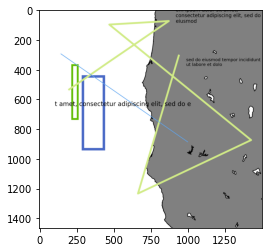

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.8051441360787824
Ratio gray pixels:  1.0146225007460459e-05
Ratio orange pixels:  0.14669710534168906
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.30608184143222505
Ratio gray pixels:  0.6192253481102586
Ratio orange pixels:  0.0
bfd21cf248
white-gray


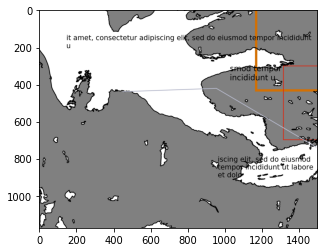

Ratio white pixels:  0.508832144555397
Ratio gray pixels:  0.420000951022349
Ratio orange pixels:  0.0
51d714d195
white-gray


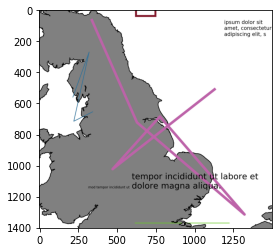

Ratio white pixels:  0.4457806637806638
Ratio gray pixels:  1.491101491101491e-05
Ratio orange pixels:  0.45346416546416546
Ratio white pixels:  0.47520130627478424
Ratio gray pixels:  1.5395381385584325e-05
Ratio orange pixels:  0.4461147655703289
Ratio white pixels:  0.49310008857395926
Ratio gray pixels:  3.247711839385887e-05
Ratio orange pixels:  0.3919362267493357
Ratio white pixels:  0.35158739255014326
Ratio gray pixels:  0.531077841451767
Ratio orange pixels:  0.0
9b4641bc09
white-gray


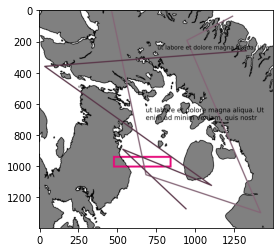

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7421085883514313
Ratio gray pixels:  0.19285422836459362
Ratio orange pixels:  0.0
990728350b
white-gray


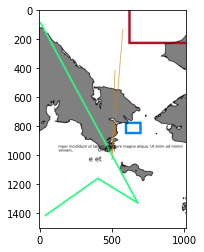

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5743461452011688
Ratio gray pixels:  4.1807147673634525e-05
Ratio orange pixels:  0.2858898628905372
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4527583540458437
Ratio gray pixels:  1.3808340237503452e-05
Ratio orange pixels:  0.4845423916045291
Ratio white pixels:  0.6066972762645915
Ratio gray pixels:  1.91958495460441e-05
Ratio orange pixels:  0.31221686121919584
Ratio white pixels:  0.9212761066275373
Ratio gray pixels:  0.014239667400342382
Ratio orange pixels:  0.0
6d9f6682eb
white-gray


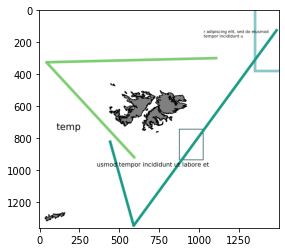

Ratio white pixels:  0.46261914744933613
Ratio gray pixels:  3.261122757978104e-06
Ratio orange pixels:  0.4706331236897275
Ratio white pixels:  0.33601495417269656
Ratio gray pixels:  1.977809937288953e-05
Ratio orange pixels:  0.5689339122045345
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.8139904912836767
Ratio gray pixels:  0.08527892234548336
Ratio orange pixels:  0.0
ee8911836d
white-gray


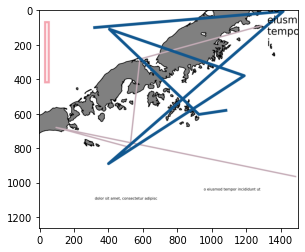

Ratio white pixels:  0.5675170644085193
Ratio gray pixels:  2.001539645881447e-05
Ratio orange pixels:  0.3460482422376187
Ratio white pixels:  0.5308
Ratio gray pixels:  3.058542413381123e-05
Ratio orange pixels:  0.3721878136200717
Ratio white pixels:  0.4568913099870298
Ratio gray pixels:  0.5062370946822309
Ratio orange pixels:  0.0
0d630b7a08
white-gray


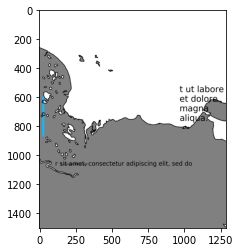

Ratio white pixels:  0.434635466850195
Ratio gray pixels:  0.45900986464785504
Ratio orange pixels:  0.0
080b2906cd
white-gray


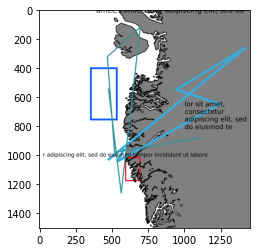

Ratio white pixels:  0.48807860786078605
Ratio gray pixels:  0.3982064206420642
Ratio orange pixels:  0.0
4d62f044c0
white-gray


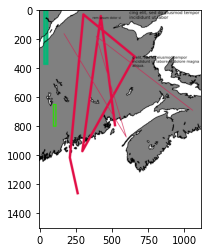

Ratio white pixels:  0.5322866811699299
Ratio gray pixels:  1.111916847957457e-05
Ratio orange pixels:  0.4235532994923858
Ratio white pixels:  0.5516988282223885
Ratio gray pixels:  1.2964348042882075e-05
Ratio orange pixels:  0.37435901271503363
Ratio white pixels:  0.5127038343919078
Ratio gray pixels:  2.822865208186309e-05
Ratio orange pixels:  0.4356424370736297
Ratio white pixels:  0.32237905369484315
Ratio gray pixels:  0.5658713450292397
Ratio orange pixels:  0.0
0fbf50523b
white-gray


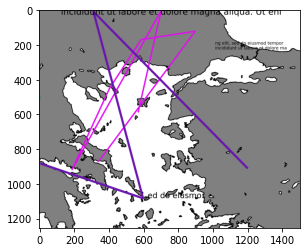

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3906236559139785
Ratio gray pixels:  0.528031007751938
Ratio orange pixels:  0.0
b40423f023
white-gray


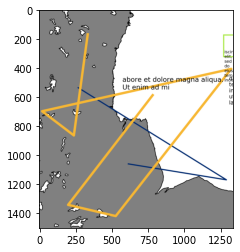

Ratio white pixels:  0.5979921046138663
Ratio gray pixels:  1.776461880088823e-05
Ratio orange pixels:  0.3538292622748581
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7643613267466478
Ratio gray pixels:  7.0571630204657725e-06
Ratio orange pixels:  0.17938696777228888
Ratio white pixels:  0.8723077370564282
Ratio gray pixels:  1.628853984874927e-05
Ratio orange pixels:  0.04291564863292612
Ratio white pixels:  0.14695720399429388
Ratio gray pixels:  1.1412268188302426e-05
Ratio orange pixels:  0.7137213504517356
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3556545358649789
Ratio gray pixels:  0.5758185654008439
Ratio orange pixels:  0.0
5001fae450
white-gray


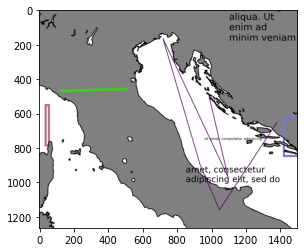

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6862421455938698
Ratio gray pixels:  0.23633920817369095
Ratio orange pixels:  0.0
8634ba2098
white-gray


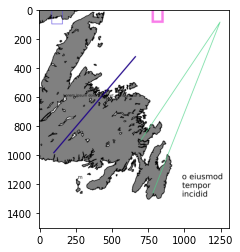

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.711692271218587
Ratio gray pixels:  3.366524419155998e-05
Ratio orange pixels:  0.21514414414414415
Ratio white pixels:  0.26498500953938403
Ratio gray pixels:  2.2894521668029437e-05
Ratio orange pixels:  0.6184644317252658
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4628500459981601
Ratio gray pixels:  0.45244096902790554
Ratio orange pixels:  0.0
72264caedb
white-gray


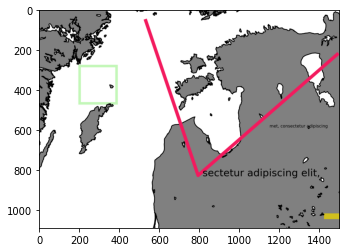

Ratio white pixels:  0.6407738883632923
Ratio gray pixels:  0.275998738568275
Ratio orange pixels:  0.0
d2a8df0484
white-gray


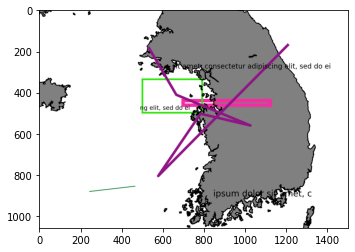

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.752388462433124
Ratio gray pixels:  2.5587345894394044e-05
Ratio orange pixels:  0.18844010234938358
Ratio white pixels:  0.7073965293965294
Ratio gray pixels:  2.382802382802383e-05
Ratio orange pixels:  0.2116109816109816
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6712600523435641
Ratio gray pixels:  0.2434979776350226
Ratio orange pixels:  0.0
f8e8bf4359
white-gray


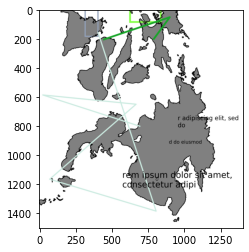

Ratio white pixels:  0.6508749677751998
Ratio gray pixels:  0.2710389275586491
Ratio orange pixels:  0.0
87d69a0496
white-gray


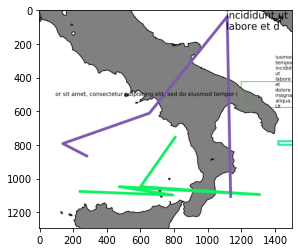

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5356091787439613
Ratio gray pixels:  0.40203091787439615
Ratio orange pixels:  0.0
02202378e3
white-gray


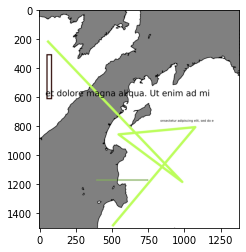

Ratio white pixels:  0.6099612676056339
Ratio gray pixels:  3.2863849765258214e-05
Ratio orange pixels:  0.29503403755868546
Ratio white pixels:  0.3404768664563617
Ratio gray pixels:  1.7875920084121977e-05
Ratio orange pixels:  0.582927970557308
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.18422110792741164
Ratio gray pixels:  0.6977817574021012
Ratio orange pixels:  0.0
b0fcda9120
white-gray


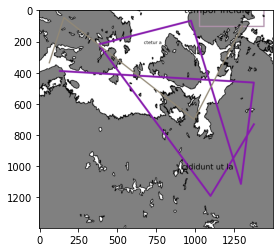

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3138679191574153
Ratio gray pixels:  2.561912894961571e-05
Ratio orange pixels:  0.5471414745231995
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.619703056768559
Ratio gray pixels:  0.2705694323144105
Ratio orange pixels:  0.0
1fc133c0c1
white-gray


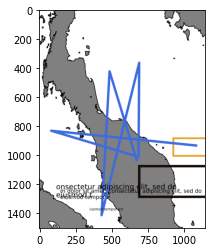

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.42100636618283677
Ratio gray pixels:  0.5157478991596639
Ratio orange pixels:  0.0
770c7e61cb
white-gray


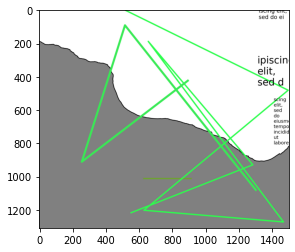

Ratio white pixels:  0.4992883895131086
Ratio gray pixels:  2.0167098818784212e-05
Ratio orange pixels:  0.44798962834917894
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4432523166534286
Ratio gray pixels:  1.0590415673815198e-06
Ratio orange pixels:  0.5294964257347101
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5731424836601308
Ratio gray pixels:  3.6601307189542484e-06
Ratio orange pixels:  0.33121359477124185
Ratio white pixels:  0.4922336928608115
Ratio gray pixels:  0.44973754494093476
Ratio orange pixels:  0.0
5cfffa42c2
white-gray


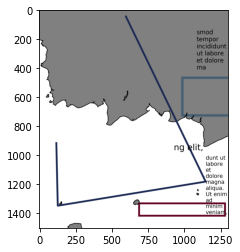

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.568338952573612
Ratio gray pixels:  0.39318813216453136
Ratio orange pixels:  0.0
cea43a0669
white-gray


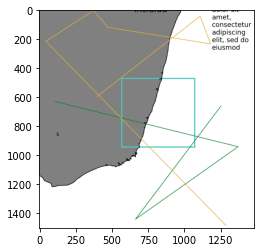

Ratio white pixels:  0.47754470284237727
Ratio gray pixels:  1.5503875968992248e-05
Ratio orange pixels:  0.42643152454780364
Ratio white pixels:  0.3267989311957248
Ratio gray pixels:  1.736806947227789e-05
Ratio orange pixels:  0.6297555110220441
Ratio white pixels:  0.6573704440026508
Ratio gray pixels:  2.6507620941020545e-05
Ratio orange pixels:  0.2704990059642147
Ratio white pixels:  0.1531958991410363
Ratio gray pixels:  1.0529232474369631e-05
Ratio orange pixels:  0.6931465779994458
Ratio white pixels:  0.7029565217391305
Ratio gray pixels:  0.2262914653784219
Ratio orange pixels:  0.0
182cff5f4e
white-gray


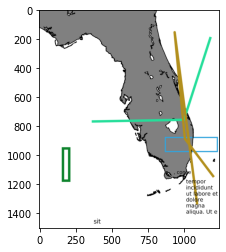

Ratio white pixels:  0.394122491529841
Ratio gray pixels:  0.5213463643471462
Ratio orange pixels:  0.0
125be67598
white-gray


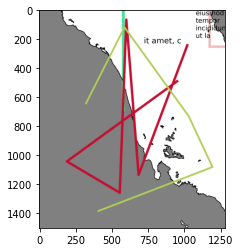

Ratio white pixels:  0.5233204358461196
Ratio gray pixels:  2.5350233488992663e-05
Ratio orange pixels:  0.3889441850122304
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6469371543489191
Ratio gray pixels:  1.4580191050779287e-05
Ratio orange pixels:  0.28907340372046253
Ratio white pixels:  0.2757054827753518
Ratio gray pixels:  1.0189228529839883e-05
Ratio orange pixels:  0.6471848617176128
Ratio white pixels:  0.48831919191919193
Ratio gray pixels:  0.4680193041526375
Ratio orange pixels:  0.0
5fe167c80c
white-gray


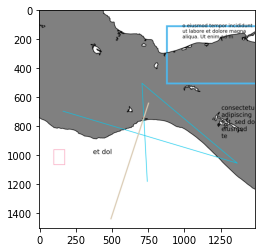

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5718044871794872
Ratio gray pixels:  2.4572649572649573e-05
Ratio orange pixels:  0.31298076923076923
Ratio white pixels:  0.2570240663900415
Ratio gray pixels:  9.95850622406639e-06
Ratio orange pixels:  0.6217289073305671
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.22800734463276837
Ratio gray pixels:  0.6516361581920904
Ratio orange pixels:  0.0
83b5af9f48
white-gray


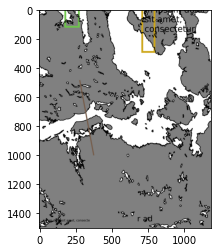

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3164444444444444
Ratio gray pixels:  9.44568729803629e-06
Ratio orange pixels:  0.6051866766094954
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5439310163243812
Ratio gray pixels:  4.739336492890995e-06
Ratio orange pixels:  0.38563191153238546
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.26367784465462885
Ratio gray pixels:  0.6664918314703353
Ratio orange pixels:  0.0
a92760335d
white-gray


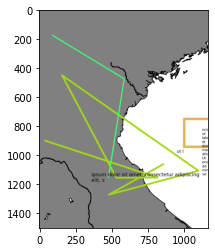

Ratio white pixels:  0.4461609018703561
Ratio gray pixels:  7.173968741993339e-06
Ratio orange pixels:  0.5164734819369715
Ratio white pixels:  0.5613843971631206
Ratio gray pixels:  4.028368794326241e-05
Ratio orange pixels:  0.3449798581560284
Ratio white pixels:  0.8473401268115942
Ratio gray pixels:  1.7210144927536233e-05
Ratio orange pixels:  0.09795742753623188
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.5365024674742037
Ratio white pixels:  0.45518658972245124
Ratio gray pixels:  0.4572574883209673
Ratio orange pixels:  0.0
6640a5d246
white-gray


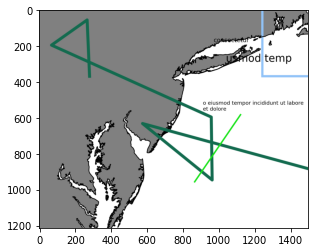

Ratio white pixels:  0.35756267806267805
Ratio gray pixels:  0.5701752136752136
Ratio orange pixels:  0.0
2d1e5212c0
white-gray


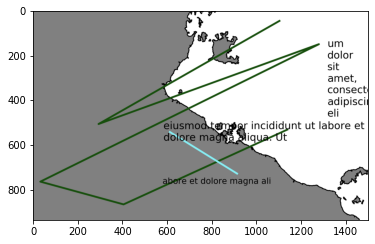

Ratio white pixels:  0.6618936801277664
Ratio gray pixels:  0.2590047912388775
Ratio orange pixels:  0.0
1449792dad
white-gray


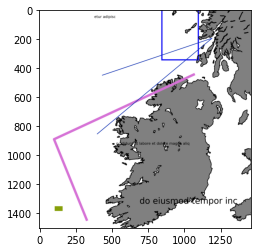

Ratio white pixels:  0.22906441717791412
Ratio gray pixels:  0.7121988752556238
Ratio orange pixels:  0.0
6e07ac525b
white-gray


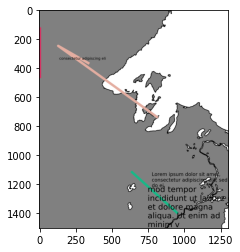

Ratio white pixels:  0.48075637790860665
Ratio gray pixels:  1.2335295766750771e-05
Ratio orange pixels:  0.45991589571068126
Ratio white pixels:  0.27838207392868825
Ratio gray pixels:  2.8132155708210663e-05
Ratio orange pixels:  0.5763650637880274
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7461104718066743
Ratio gray pixels:  0.16624702723436902
Ratio orange pixels:  0.0
ee399fd826
white-gray


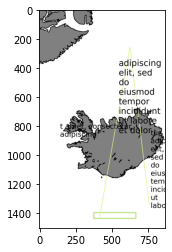

Ratio white pixels:  0.21298296059637914
Ratio gray pixels:  0.6839414270500532
Ratio orange pixels:  0.0
dc593073a7
white-gray


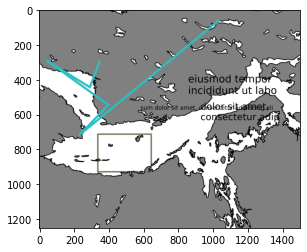

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4382064850843061
Ratio gray pixels:  0.5117821011673152
Ratio orange pixels:  0.0
5f0011bcaf
white-gray


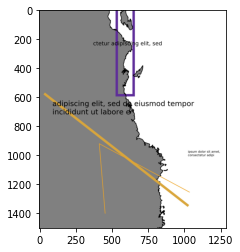

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5230970234037718
Ratio gray pixels:  2.226766643944558e-05
Ratio orange pixels:  0.37619359236537153
Ratio white pixels:  0.8629265927977839
Ratio gray pixels:  2.0313942751615882e-05
Ratio orange pixels:  0.09402539242843952
Ratio white pixels:  0.7626073546856466
Ratio gray pixels:  0.12662514827995255
Ratio orange pixels:  0.0
1c1d12fa52
white-gray


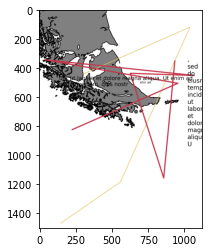

Ratio white pixels:  0.8053551985720661
Ratio gray pixels:  0.12680946006247212
Ratio orange pixels:  0.0
63c196b325
white-gray


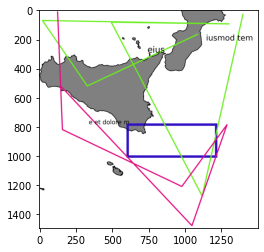

Ratio white pixels:  0.804170976007454
Ratio gray pixels:  0.10816398788725833
Ratio orange pixels:  0.0
76068d6591
white-gray


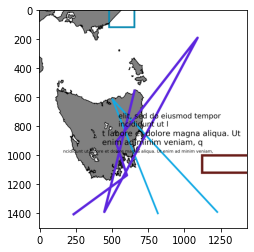

Ratio white pixels:  0.20961720430107528
Ratio gray pixels:  0.6408983870967742
Ratio orange pixels:  0.0
47825b6d47
white-gray


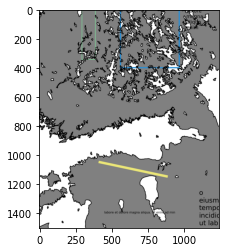

Ratio white pixels:  0.2854918032786885
Ratio gray pixels:  2.4590163934426228e-05
Ratio orange pixels:  0.587761839708561
Ratio white pixels:  0.5833893557422969
Ratio gray pixels:  0.367515406162465
Ratio orange pixels:  0.0
e13465e279
white-gray


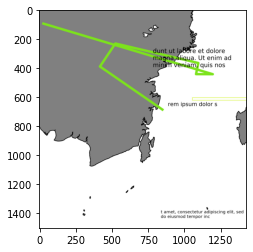

Ratio white pixels:  0.3375171120487576
Ratio gray pixels:  9.845288326300985e-06
Ratio orange pixels:  0.5868640412564463
Ratio white pixels:  0.4800482080558199
Ratio gray pixels:  2.029812876625436e-05
Ratio orange pixels:  0.3940964161116397
Ratio white pixels:  0.33746892655367233
Ratio gray pixels:  0.5312404268675455
Ratio orange pixels:  0.0
3f0eca7546
white-gray


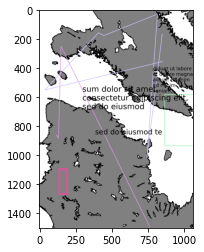

Ratio white pixels:  0.053483389830508474
Ratio gray pixels:  0.874681581920904
Ratio orange pixels:  0.0
5c0b350922
white-gray


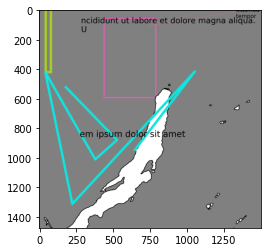

Ratio white pixels:  0.3857260130718954
Ratio gray pixels:  1.7254901960784314e-05
Ratio orange pixels:  0.5680402614379085
Ratio white pixels:  0.6776382978723404
Ratio gray pixels:  0.2660731042007638
Ratio orange pixels:  0.0
4b6bdc5477
white-gray


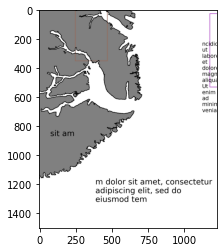

Ratio white pixels:  0.7756542102640758
Ratio gray pixels:  2.441454907822621e-05
Ratio orange pixels:  0.17672097658196312
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5036294779938587
Ratio gray pixels:  1.7741385192766974e-05
Ratio orange pixels:  0.4271525076765609
Ratio white pixels:  0.2950668590668591
Ratio gray pixels:  1.3468013468013468e-05
Ratio orange pixels:  0.6385791245791246
Ratio white pixels:  0.516132332499305
Ratio gray pixels:  1.7236586043925494e-05
Ratio orange pixels:  0.4428546010564359
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.1750328407224959
Ratio gray pixels:  0.6745002736726875
Ratio orange pixels:  0.0
f4b00d2bb5
white-gray


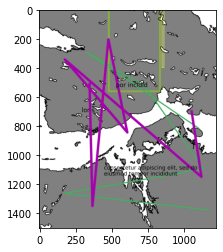

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.7053965267727931
Ratio gray pixels:  1.4471780028943561e-05
Ratio orange pixels:  0.22111239749155812
Ratio white pixels:  0.6144093925472179
Ratio gray pixels:  0.34403726391015826
Ratio orange pixels:  0.0
2cb3bcc397
white-gray


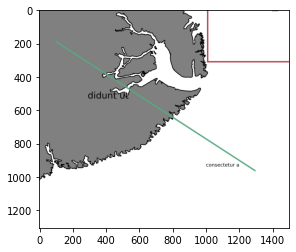

Ratio white pixels:  0.20705850706119705
Ratio gray pixels:  0.7009145931405515
Ratio orange pixels:  0.0
c9db609409
white-gray


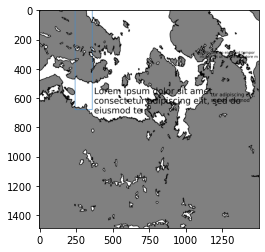

Ratio white pixels:  0.549968253968254
Ratio gray pixels:  0.3850942140296979
Ratio orange pixels:  0.0
ecd427ed0a
white-gray


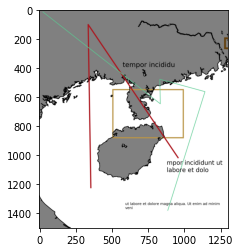

Ratio white pixels:  0.7302236842105263
Ratio gray pixels:  2.255639097744361e-05
Ratio orange pixels:  0.20738533834586467
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3323756708407871
Ratio gray pixels:  2.4448419797257005e-05
Ratio orange pixels:  0.5727787716159809
Ratio white pixels:  0.4292277325437947
Ratio gray pixels:  0.5255376264495435
Ratio orange pixels:  0.0
bc9655d03f
white-gray


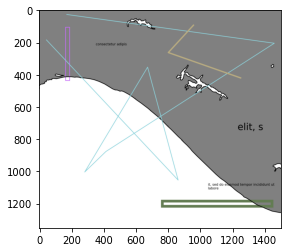

Ratio white pixels:  0.5128257820927724
Ratio gray pixels:  0.38728478964401297
Ratio orange pixels:  0.0
edcf4b144b
white-gray


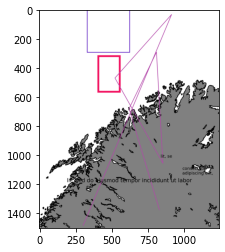

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.546095637975274
Ratio gray pixels:  1.912759505481689e-05
Ratio orange pixels:  0.4070104968509447
Ratio white pixels:  0.5331170991350632
Ratio gray pixels:  0.3590998003992016
Ratio orange pixels:  0.0
4951f85c13
white-gray


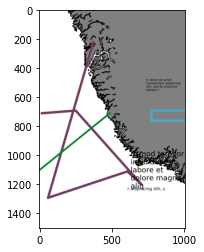

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.818562569213732
Ratio gray pixels:  0.1187718715393134
Ratio orange pixels:  0.0
0b465cfcd9
white-gray


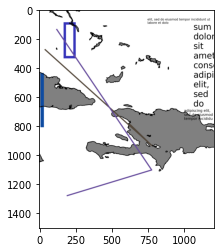

Ratio white pixels:  0.3490602593440122
Ratio gray pixels:  6.102212051868802e-06
Ratio orange pixels:  0.621951690821256
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.3543073029645698
Ratio gray pixels:  2.6030368763557484e-05
Ratio orange pixels:  0.5669436008676789
Ratio white pixels:  0.17101548946716233
Ratio gray pixels:  6.815365551425031e-06
Ratio orange pixels:  0.71095229244114
Ratio white pixels:  0.7047480673033197
Ratio gray pixels:  1.5006821282401092e-05
Ratio orange pixels:  0.25318144611186905
Ratio white pixels:  0.315400796812749
Ratio gray pixels:  2.0185922974767595e-05
Ratio orange pixels:  0.600923240371846
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.2675007052186178
Ratio gray pixels:  1.3164080865068171e-05
Ratio orange pixels:  0.6339374706158909
Ratio white pixels:  0.5649237089201

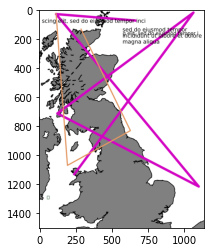

Ratio white pixels:  0.5872700548081714
Ratio gray pixels:  6.4773293472845045e-06
Ratio orange pixels:  0.3376965620328849
Ratio white pixels:  0.4059496516071027
Ratio gray pixels:  0.5561006967857945
Ratio orange pixels:  0.0
e3145bbb36
white-gray


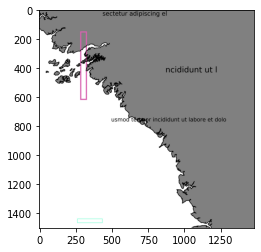

Ratio white pixels:  0.40405756457564573
Ratio gray pixels:  9.34809348093481e-06
Ratio orange pixels:  0.5475321033210332
Ratio white pixels:  0.7270316573556797
Ratio gray pixels:  0.1800626939788951
Ratio orange pixels:  0.0
12b9743033
white-gray


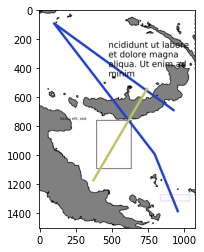

Ratio white pixels:  0.8532320376914017
Ratio gray pixels:  1.4134275618374558e-05
Ratio orange pixels:  0.07611260306242638
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.41330355791067375
Ratio gray pixels:  2.4728740852889227e-05
Ratio orange pixels:  0.466965430229624
Ratio white pixels:  0.7531920903954802
Ratio gray pixels:  2.4952919020715632e-05
Ratio orange pixels:  0.1690819209039548
Ratio white pixels:  0.7686227316141356
Ratio gray pixels:  0.1897378223495702
Ratio orange pixels:  0.0
9b96de8a35
white-gray


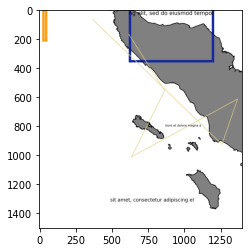

Ratio white pixels:  0.7301489916963226
Ratio gray pixels:  0.2295065243179122
Ratio orange pixels:  0.0
7b514a9342
white-gray


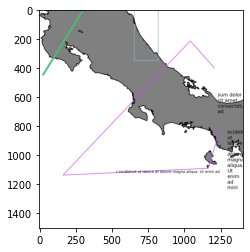

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.5006978584729982
Ratio gray pixels:  0.43508659217877094
Ratio orange pixels:  0.0
c5944e2a17
white-gray


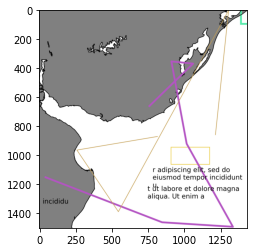

Ratio white pixels:  0.32534338588074024
Ratio gray pixels:  0.6312634224354581
Ratio orange pixels:  0.0
101a5e1daa
white-gray


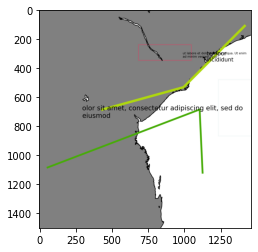

Ratio white pixels:  0.460689156626506
Ratio gray pixels:  9.103078982597054e-06
Ratio orange pixels:  0.5020358768406962
Ratio white pixels:  0.34111306901615274
Ratio gray pixels:  2.98580518844836e-05
Ratio orange pixels:  0.5602178169358786
Ratio white pixels:  0.12361204013377926
Ratio gray pixels:  1.0256410256410256e-05
Ratio orange pixels:  0.727866220735786
Ratio white pixels:  0.46325062447960036
Ratio gray pixels:  2.6644462947543715e-05
Ratio orange pixels:  0.42690591174021647
Ratio white pixels:  0.6157062068965518
Ratio gray pixels:  1.9310344827586207e-05
Ratio orange pixels:  0.2832951724137931
Ratio white pixels:  0.44878991981672395
Ratio gray pixels:  0.46719679266895764
Ratio orange pixels:  0.0
b244625be7
white-gray


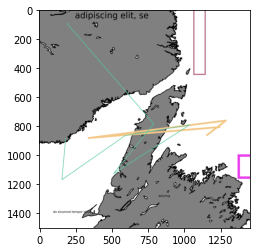

Ratio white pixels:  0.7364626904208624
Ratio gray pixels:  0.21488355280144592
Ratio orange pixels:  0.0
647b6df5e3
white-gray


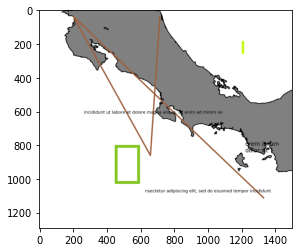

Ratio white pixels:  0.3004858662188637
Ratio gray pixels:  2.239014833473272e-05
Ratio orange pixels:  0.5874648754547999
Ratio white pixels:  0.5840677048070413
Ratio gray pixels:  1.399232678853532e-05
Ratio orange pixels:  0.3503805010155721
Ratio white pixels:  0.36265524625267664
Ratio gray pixels:  1.998572448251249e-05
Ratio orange pixels:  0.557976683321437
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.4282132060461416
Ratio gray pixels:  0.5402349509413948
Ratio orange pixels:  0.0
7f79963011
white-gray


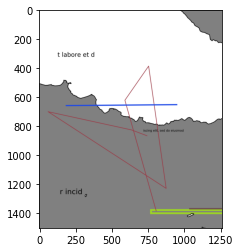

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.26275072971395214
Ratio gray pixels:  2.2183304144775247e-05
Ratio orange pixels:  0.6094080560420315
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6631591632560254
Ratio gray pixels:  1.1368804001819008e-05
Ratio orange pixels:  0.303068667576171
Ratio white pixels:  0.6473006421482779
Ratio gray pixels:  1.8096906012842967e-05
Ratio orange pixels:  0.29652948044366606
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.35587491115849323
Ratio gray pixels:  1.8952854773750296e-05
Ratio orange pixels:  0.5754925373134329
Ratio white pixels:  0.386760874789714
Ratio gray pixels:  0.5427772170151406
Ratio orange pixels:  0.0
e74b182da4
white-gray


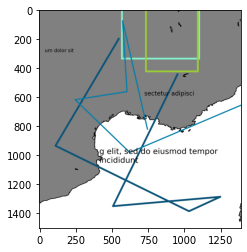

Ratio white pixels:  0.4810220174091142
Ratio gray pixels:  0.477057859703021
Ratio orange pixels:  0.0
162bfdbe0a
white-gray


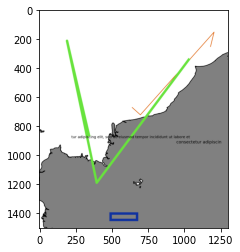

Ratio white pixels:  0.33915585135884635
Ratio gray pixels:  1.7748197448696617e-05
Ratio orange pixels:  0.60751026067665
Ratio white pixels:  0.548046027131783
Ratio gray pixels:  2.7616279069767442e-05
Ratio orange pixels:  0.34773401162790696
Ratio white pixels:  0.690889874353289
Ratio gray pixels:  0.23148755851194874
Ratio orange pixels:  0.0
749e9eb706
white-gray


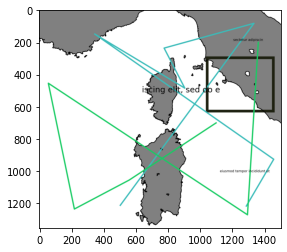

Ratio white pixels:  0.46978308457711443
Ratio gray pixels:  0.460271144278607
Ratio orange pixels:  0.0
22c1364f4e
white-gray


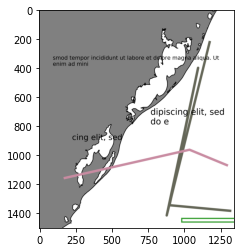

Ratio white pixels:  0.9146153466567974
Ratio gray pixels:  1.4310387367382186e-05
Ratio orange pixels:  0.039170490994325194
Ratio white pixels:  0.4957447241291635
Ratio gray pixels:  0.4662512077294686
Ratio orange pixels:  0.0
f24e50a258
white-gray


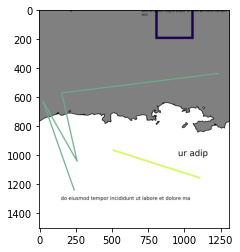

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.1370551839464883
Ratio gray pixels:  0.7591265328874025
Ratio orange pixels:  0.0
bfa5a6c134
white-gray


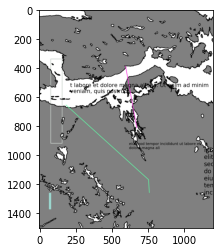

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.45880908004778975
Ratio gray pixels:  1.4336917562724014e-06
Ratio orange pixels:  0.4846657108721625
Ratio white pixels:  0.3848554274735831
Ratio gray pixels:  1.2968299711815562e-05
Ratio orange pixels:  0.5357483189241115
Ratio white pixels:  0.31340965207631877
Ratio gray pixels:  2.6936026936026937e-05
Ratio orange pixels:  0.5625373737373738
Ratio white pixels:  0.3981407506702413
Ratio gray pixels:  1.8766756032171583e-05
Ratio orange pixels:  0.553952636282395
Ratio white pixels:  0.3169604916593503
Ratio gray pixels:  1.9315188762071993e-05
Ratio orange pixels:  0.5710594088381621
Ratio white pixels:  0.3820746785361029
Ratio gray pixels:  1.483679525222552e-05
Ratio orange pixels:  0.5093333333333333
Ratio white pixels:  0.5214863648398199
Ratio gray pixels:  1.2708498808578237e-05
Ratio orange pixels:  0.41302832936192746
Ratio white pixels:  0.6234004160166406
Ratio gray pixel

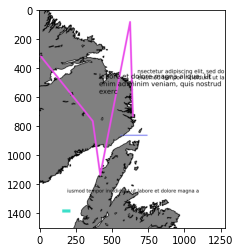

Ratio white pixels:  0.7275393081761006
Ratio gray pixels:  2.6729559748427674e-05
Ratio orange pixels:  0.19040723270440252
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.30789227642276423
Ratio gray pixels:  0.5798163956639566
Ratio orange pixels:  0.0
fc36c49d0b
white-gray


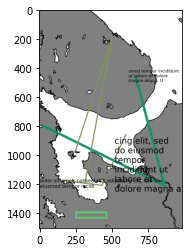

Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.0
Ratio gray pixels:  0.0
Ratio orange pixels:  0.0
Ratio white pixels:  0.6024645969498911
Ratio gray pixels:  0.28516013071895424
Ratio orange pixels:  0.0
4f02e1cd27
white-gray


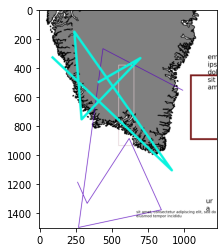

Ratio white pixels:  0.44741952506596305
Ratio gray pixels:  0.47480123131046614
Ratio orange pixels:  0.0
3276d8b20e
white-gray


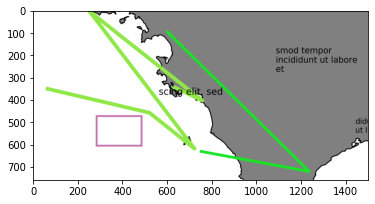

In [188]:
IMAGE_TYPE = 'white-gray'
N_IMAGES_TO_PLOT = 100
n_ploted_images = 0

for image_id in target['id']:
# for image_id in ['45d72bcfc3', '89af34f006', 'fed8eae9f9']:
    map_image = MapImageDev(image_id=image_id, image_path=map_id_to_path[image_id])
    if map_image.image_type == IMAGE_TYPE:
        print(map_image.image_id)
        print(map_image.image_type)
        map_image.plot()
        
        n_ploted_images += 1
        if n_ploted_images >= N_IMAGES_TO_PLOT:
            break